In [3]:
!python3.7 -m pip install transformers==4.9.2

You should consider upgrading via the '/usr/local/bin/python3.7 -m pip install --upgrade pip' command.


In [13]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from collections import defaultdict

%matplotlib inline

In [14]:
%config Completer.use_jedi = False

In [4]:
import pandas as pd
import numpy as np
from transformers import GPT2LMHeadModel, GPT2Tokenizer


model_name_or_path = "sberbank-ai/rugpt3large_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path)
# model = GPT2LMHeadModel.from_pretrained(model_name_or_path).cuda()

In [7]:
BASE_PATH = "data/"

In [8]:
train_data = pd.read_csv(BASE_PATH + 'rus_train_dataset.csv', encoding='utf-8', sep='|')
en_ru_aux_data = pd.read_csv(BASE_PATH + 'en_to_rus_train_dataset.csv', encoding='utf-8', sep='|')

In [32]:
%%time
train_bundle = np.load(BASE_PATH + 'train_dataset_bundle.npy', allow_pickle=True)

CPU times: user 540 ms, sys: 975 ms, total: 1.52 s
Wall time: 2.02 s


In [901]:
%%time
ext_bundle = np.load(BASE_PATH + 'en_ru_aux_dataset_bundle.npy', allow_pickle=True)

CPU times: user 342 ms, sys: 756 ms, total: 1.1 s
Wall time: 1.52 s


In [34]:
train_bundle[0]

{'q': {'tokens': array([[ 4182,  7291, 13004, 18112,  1612,  7977,   282,  3723,   707,
             35]]),
  'likelihood': 55.590515,
  'embed': array([[[-0.10105464,  0.01616081,  0.42873275, ..., -0.10581393,
            1.0124849 , -0.6411731 ],
          [ 0.07145833, -0.48871338,  0.47270167, ...,  0.35405552,
            0.0315832 ,  0.05505302],
          [-0.3825777 ,  0.09196834, -0.23344886, ..., -0.5369391 ,
           -0.18912771, -0.5008245 ],
          ...,
          [ 0.5705487 , -0.1342039 ,  0.20777151, ..., -1.1217256 ,
            1.155151  ,  0.0294059 ],
          [-0.3563176 , -0.388275  , -0.42374414, ..., -0.4476165 ,
            0.7153409 , -0.28883162],
          [-1.1544749 , -0.06022687, -0.30357346, ..., -0.47898966,
            0.8051275 ,  0.32764208]]], dtype=float32)},
 'a1': {'tokens': array([[ 4182,  7291, 13004, 18112,  1612,  7977,   282,  3723,   707,
             35,  9266,   277]]),
  'likelihood': 67.78197,
  'embed': array([[[-0.10105464,  0.0

(array([1447.,    0.,    0.,    0.,    0., 1303.,    0.,    0.,    0.,
        1311.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

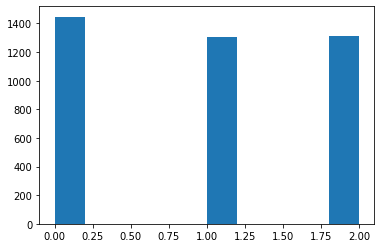

In [15]:
plt.hist(train_data["right_answer_id"].values)

In [27]:
from collections import Counter
Counter(en_ru_aux_data["right_answer_id"].values)

Counter({'2.0': 626,
         '0.0': 390,
         '1.0': 626,
         nan: 69,
         '0,0': 210,
         'right_answer_id': 2,
         '1,0': 14,
         '2,0': 3,
         '1.0.': 1})

(array([ 71.,   0.,   0., 600.,   0.,   0., 641.,   0.,   0., 629.]),
 array([-1. , -0.7, -0.4, -0.1,  0.2,  0.5,  0.8,  1.1,  1.4,  1.7,  2. ]),
 <BarContainer object of 10 artists>)

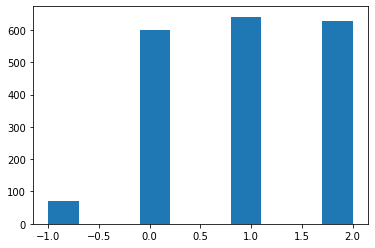

In [29]:
def _fix_input(x):
    if x in ['0.0', '1.0', '2.0', '0,0', '1,0', '2,0', '1.0.']:
        return float(x[0])
    return -1
plt.hist([_fix_input(x) for x in en_ru_aux_data["right_answer_id"].values])

In [43]:
def evaluate(generator, pipe, aggregator):
    for _split in generator:
        aggregator(pipe(_split))

In [902]:
from scipy.stats import norm

def p_val(x):
    return 2 * min(norm.cdf(-x), norm.cdf(x))

class ScoreAggregator:
    def __init__(self):
        self._scores = []
        self._baselines = []
    def __call__(self, update):
        score, baseline = update
        self._scores.append(score)
        self._baselines.append(baseline)
    def calc_info(self):
        diff = np.array(self._scores) - np.array(self._baselines)
        return {"mean_score": np.mean(self._scores), "std_score": np.std(self._scores),
               "mean_diff": np.mean(diff), "std_diff": np.std(diff), "p_value": p_val(np.mean(diff) / (np.std(diff) + 1e-9))}


In [903]:
train_raw_targets = train_data["right_answer_id"].values
def extract_targets_in_domain(idxs: np.array, is_pairwise: bool) -> np.array:
    if not is_pairwise:
        return train_raw_targets[idxs]
    targets = np.zeros(len(idxs) * 3)
    for i, t in enumerate(train_raw_targets[idxs]):
        targets[3 * i + t] = 1
    return targets

In [910]:
def _fix_input(x):
    if x in ['0.0', '1.0', '2.0', '0,0', '1,0', '2,0', '1.0.']:
        return float(x[0])
    return -1

prepared_en_ru_targets = np.array([_fix_input(x) for x in en_ru_aux_data["right_answer_id"].values])

def extract_targets_ext(is_pairwise: bool) -> np.array:
    assert is_pairwise
    N = prepared_en_ru_targets.shape[0]
    targets = np.zeros(N * 3)
    for i, t in enumerate(prepared_en_ru_targets):
        t = int(t)
        if t == -1:
            continue
        targets[3 * i + t] = 1
    return targets

In [462]:
np.arange(5) // 3

array([0, 0, 0, 1, 1])

In [57]:
train_bundle[0]['q']['embed'].shape

(1, 10, 1536)

In [62]:
train_bundle[0]['q']['tokens']

array([[ 4182,  7291, 13004, 18112,  1612,  7977,   282,  3723,   707,
           35]])

In [58]:
train_bundle[1]['q']['embed'].shape

(1, 12, 1536)

In [61]:
train_bundle[1]['q']['tokens']

array([[46928,   411, 22672,  3541,  5511,  1888, 26756, 26109,  2422,
          334, 40730,    35]])

In [239]:
train_bundle[0]['q']['embed'][0][-1].reshape(-1).shape

(1536,)

In [1178]:
H = 32
np.random.seed(0)
random_proj = np.random.normal(size=(1536, H))
np.mean(random_proj)

-0.003485747948384979

In [371]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [1067]:
tf_idf_vectorizer = TfidfVectorizer()

In [1068]:
tf_idf_train = tf_idf_vectorizer.fit_transform(train_data["question"].values)

In [1070]:
svd = TruncatedSVD(n_components=16, random_state=0)

In [1071]:
tf_idf_train_svd_projected = svd.fit_transform(tf_idf_train)

In [1073]:
tf_idf_ext_projected = svd.transform(tf_idf_vectorizer.transform(en_ru_aux_data["question"].values))

In [1117]:
train_predictions_by_model_v1 =  np.load("data/original_train_predictions_by_model_v1.npy", allow_pickle=True)
ext_predictions_by_model_v1 =  np.load("data/ext_predictions_by_model_v1.npy", allow_pickle=True)

In [1179]:
def make_emb_random_proj(emb: np.array):
    emb_proj = np.matmul(emb, random_proj)
    emb_proj /= np.sum(np.abs(emb_proj))
    return emb_proj


def extract_features_in_domain_v1(bundle: np.array, idxs: np.array, reset_cache: bool=True, is_pairwise: bool=False, is_train: bool=True) -> np.array:
    res = []

    for idx in idxs:
        emb = bundle[idx]['q']['embed'][0][-1].reshape(-1)
    #         emb /= np.sum(np.abs(emb))
        emb_proj = make_emb_random_proj(emb)
#         tf_idf_emb = tf_idf_train_svd_projected[idx] if is_train else tf_idf_ext_projected[idx]
#         tf_idf_emb /= np.sum(np.abs(tf_idf_emb))

        ll = np.array([
            bundle[idx]['a1']['likelihood'],
            bundle[idx]['a2']['likelihood'],
            bundle[idx]['a3']['likelihood'],
        ])
        embs = np.array([
            bundle[idx]['a1']['embed'][0][-1].reshape(-1),
            bundle[idx]['a2']['embed'][0][-1].reshape(-1),
            bundle[idx]['a3']['embed'][0][-1].reshape(-1),
        ])

        dists = np.sum(np.abs(embs - emb), axis=1)

        ll = (ll - np.mean(ll)) / np.std(ll)
        vec = np.concatenate([
            [np.argmax(ll)],
#                 tf_idf_emb,
#                 emb_proj,
        ])
        for j in range(3):
            emb_a = embs[j]
            prediction = train_predictions_by_model_v1[3 * idx + j] if is_train else ext_predictions_by_model_v1[3 * idx + j]
            res.append(np.concatenate([
                vec,
                np.array([np.sum(np.abs(emb - emb_a))]),
                make_emb_random_proj(emb_a),
                np.array([ll[j], j == np.argmax(ll), prediction]),
            ]))
    return np.array(res)

In [1180]:
f = extract_features_in_domain_v1(train_bundle, [0], True, True, True)
f.shape, f[:, -5:]

((3, 37),
 array([[ 0.01061269, -0.02169646,  1.20351601,  1.        , -0.86392146],
        [-0.01026207,  0.01641331, -1.24492359,  0.        , -0.87211543],
        [ 0.01203792, -0.030492  ,  0.04140474,  0.        , -0.79791766]]))

In [715]:
import catboost

In [859]:
np.arange(3) == np.arange(1,4)

array([False, False, False])

In [1174]:
def fit_predict_with_catboost(model, X_train, X_val, X_test, y_train, y_val, val_ratio: float, is_pairwise: bool, weights:np.array):
    train_group_id = np.repeat(np.arange(X_train.shape[0] // 3), 3) if is_pairwise else None
    val_group_id = np.repeat(np.arange(X_val.shape[0] // 3), 3) if is_pairwise else None
    train_pool = catboost.Pool(X_train, y_train, group_id=train_group_id, weight=weights)
    val_pool = catboost.Pool(X_val, y_val, group_id=val_group_id)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100)
    return model.predict(X_test)

def calc_metric(y_true, y_score, is_pairwise: bool):
    if not is_pairwise:
        return np.mean(y_true == y_score)
    y_score = y_score.reshape(-1, 3)
    y_true = y_true.reshape(-1, 3)
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_score, axis=1))

In [1181]:
class PiperV1:
    def __init__(self, model, val_ratio: float, is_pairwise: bool, ext_weight:float, fit_predict_with_model):
        self.model = model
        self.reset_cache = True
        self.is_pairwise = is_pairwise
        self.val_ratio = val_ratio
        self.ext_weight = ext_weight
        self.fit_predict_with_model = fit_predict_with_model
        self.iter = 0

    def pipe(self, _split):
        train_val_idx, test_idx = _split

        np.random.seed(self.iter)
        self.iter += 1
        ids = np.arange(len(train_val_idx))
        np.random.shuffle(ids)
        N = int(len(train_val_idx) * self.val_ratio)
        train_idx = train_val_idx[N:]
        val_idx = train_val_idx[:N]

        X_ext = extract_features_in_domain_v1(
            ext_bundle,
            np.arange(len(prepared_en_ru_targets)),
            self.reset_cache,
            self.is_pairwise,
            False
        )
        y_ext = extract_targets_ext(self.is_pairwise)

        X_train = extract_features_in_domain_v1(train_bundle, train_idx, self.reset_cache, self.is_pairwise, True)
        X_val = extract_features_in_domain_v1(train_bundle, val_idx, self.reset_cache, self.is_pairwise, True)
        X_test = extract_features_in_domain_v1(train_bundle, test_idx, self.reset_cache, self.is_pairwise, True)

        y_train = extract_targets_in_domain(train_idx, self.is_pairwise)
        y_val = extract_targets_in_domain(val_idx, self.is_pairwise)
        y_test = extract_targets_in_domain(test_idx, self.is_pairwise)

        train_weights = np.ones_like(y_train)
        ext_weights = np.ones_like(y_ext) * self.ext_weight
        
        if True:  # useful for debug
            train_weights = np.concatenate([train_weights, ext_weights], axis=0)
            X_train = np.concatenate([X_train, X_ext], axis=0)
            y_train = np.concatenate([y_train, y_ext], axis=0)

        y_test_pred = self.fit_predict_with_model(self.model, X_train, X_val, X_test, y_train, y_val, self.val_ratio, self.is_pairwise, train_weights)
        y_test_baseline = np.array([np.eye(3)[int(x)] for x in X_test[::3, 0]]).reshape(-1)  # is sber-gpt3
        metric = calc_metric(y_test, y_test_pred, self.is_pairwise)
        base_metric = calc_metric(y_test, y_test_baseline, self.is_pairwise)
        return (metric, base_metric)

In [1110]:
from sklearn.linear_model import LinearRegression, LogisticRegression

In [1111]:
def fit_predict_with_sklearn(model, X_train, X_val, X_test, y_train, y_val, val_ratio: float, is_pairwise: bool, weights:np.array):
#     train_group_id = np.repeat(np.arange(X_train.shape[0] // 3), 3) if is_pairwise else None
#     val_group_id = np.repeat(np.arange(X_val.shape[0] // 3), 3) if is_pairwise else None
#     train_pool = catboost.Pool(X_train, y_train, group_id=train_group_id, weight=weights)
#     val_pool = catboost.Pool(X_val, y_val, group_id=val_group_id)
#     model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100)
    model.fit(X_train, y_train, weights)
    return model.predict(X_test)

In [1112]:
from sklearn.model_selection import RepeatedStratifiedKFold
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

In [1206]:
score_aggregator = ScoreAggregator()
piper = PiperV1(catboost.CatBoost({"loss_function":"QueryRMSE", "rsm":0.3}), 0.2, True, 0.1, fit_predict_with_catboost)

evaluate(
    generator=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=13).split(np.arange(train_data.shape[0]), train_raw_targets),
    pipe=piper.pipe,
    aggregator=score_aggregator
)

0:	learn: 0.4706735	test: 0.4713622	best: 0.4713622 (0)	total: 7.2ms	remaining: 7.19s
1:	learn: 0.4705685	test: 0.4713144	best: 0.4713144 (1)	total: 12.9ms	remaining: 6.42s
2:	learn: 0.4704492	test: 0.4713106	best: 0.4713106 (2)	total: 20.8ms	remaining: 6.93s
3:	learn: 0.4703295	test: 0.4712848	best: 0.4712848 (3)	total: 24.6ms	remaining: 6.12s
4:	learn: 0.4701814	test: 0.4711944	best: 0.4711944 (4)	total: 30ms	remaining: 5.96s
5:	learn: 0.4699809	test: 0.4711317	best: 0.4711317 (5)	total: 33.9ms	remaining: 5.62s
6:	learn: 0.4699029	test: 0.4711625	best: 0.4711317 (5)	total: 39.6ms	remaining: 5.62s
7:	learn: 0.4697884	test: 0.4711167	best: 0.4711167 (7)	total: 43.3ms	remaining: 5.37s
8:	learn: 0.4696406	test: 0.4711114	best: 0.4711114 (8)	total: 48.7ms	remaining: 5.37s
9:	learn: 0.4695059	test: 0.4711042	best: 0.4711042 (9)	total: 52.6ms	remaining: 5.2s
10:	learn: 0.4693805	test: 0.4710641	best: 0.4710641 (10)	total: 60.9ms	remaining: 5.47s
11:	learn: 0.4692419	test: 0.4709755	best: 0.

In [1207]:
score_aggregator.calc_info()

{'mean_score': 0.3814319645659511,
 'std_score': 0.011065598922396114,
 'mean_diff': 0.026345894000811932,
 'std_diff': 0.01658368026740085,
 'p_value': 0.11213631720066593}

In [1165]:
score_aggregator.calc_info()  # without tf-idf

{'mean_score': 0.375460194257115,
 'std_score': 0.012005133127796764,
 'mean_diff': 0.02037700179957464,
 'std_diff': 0.015101647465220256,
 'p_value': 0.17723323716286143}

In [1183]:
score_aggregator.calc_info()

{'mean_score': 0.3814319645659511,
 'std_score': 0.011065598922396114,
 'mean_diff': 0.026345894000811932,
 'std_diff': 0.01658368026740085,
 'p_value': 0.11213631720066593}

In [1196]:
score_aggregator._scores

[0.3714637146371464,
 0.3694581280788177,
 0.3645320197044335,
 0.3694581280788177,
 0.3448275862068966]

In [1150]:
np.std(score_aggregator._scores), np.min(score_aggregator._scores)

(0.01451372974885712, 0.3472906403940887)

In [1151]:
np.std(score_aggregator._baselines), np.min(score_aggregator._baselines)

(0.018259411388373576, 0.3226600985221675)

In [1152]:
piper.model.best_score_

{'learn': {'QueryRMSE': 0.39813710979840705},
 'validation': {'QueryRMSE': 0.46689855293622134}}

In [1153]:
piper.model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'QueryRMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 0.30000001192092896,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'od_wait': 100,
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'QueryRMSE',
 'learning_rate': 0.029999999329447743,
 'score_function': 'Cosine',
 'task_type